
<style>
  .blue-cell {
    background-color: #007BFF; /* Bleu */
    color: white;
    padding: 20px;
    border-radius: 10px;
    font-family: Arial, sans-serif;
  }

  .blue-cell h1, .blue-cell h2 {
    color: white;
  }

  .blue-cell ul {
    list-style-type: disc;
    padding-left: 20px;
  }

  .blue-cell li {
    margin-bottom: 10px;
  }

  .blue-cell strong {
    color: #FFD700; /* Or pour mots importants */
  }
</style>

<div class="blue-cell">
  <h1>Répartition travail Machine Learning 2</h1>

  <h2>Phase 1</h2>
  <ul>
    <li>Kernel Kaggle</li>
    <li>Prétraitement</li>
    <li>Créer le répositoire GitHub et faire les modèles</li>
    <li>Tester <strong>SHAP</strong> sur un modèle jouet pour comprendre comment l'utiliser</li>
    <li>Installer <strong>MLflow</strong>, CI/CD basique, tests unitaires simples</li>
  </ul>

  <h2>Phase 2</h2>
  <ul>
    <li>Pipeline final</li>
    <li>Conception application</li>
    <li>Intégration du modèle avec <strong>MLflow</strong>, modèle avec les vraies données</li>
    <li> <strong>PowerPoin</strong>t</li>
  </ul>
</div>


## Phase 1

 ## Kernel Kaggle (exploration + premier prétraitement).

In [12]:
import pandas as pd

# Charger les datasets principaux (échantillons pour aperçu rapide)
train_transaction = pd.read_csv("E:/Projet_ML_class/test_transaction.csv", nrows=5000)  # Prendre 5000 lignes pour aller vite
train_identity = pd.read_csv("E:/Projet_ML_class/train_identity.csv", nrows=5000)

# Aperçu du début des datasets
head_transaction = train_transaction.head()
head_identity = train_identity.head()

# Statistiques descriptives
desc_transaction = train_transaction.describe()
desc_identity = train_identity.describe()

head_transaction, head_identity, desc_transaction, desc_identity


(   TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
 0        3663549       18403224           31.95         W  10409  111.0   
 1        3663550       18403263           49.00         W   4272  111.0   
 2        3663551       18403310          171.00         W   4476  574.0   
 3        3663552       18403310          284.95         W  10989  360.0   
 4        3663553       18403317           67.95         W  18018  452.0   
 
    card3       card4  card5  card6  ...  V330  V331  V332  V333 V334 V335  \
 0  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
 1  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
 2  150.0        visa  226.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
 3  150.0        visa  166.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
 4  150.0  mastercard  117.0  debit  ...   NaN   NaN   NaN   NaN  NaN  NaN   
 
    V336  V337  V338  V339  
 0   NaN   NaN   NaN   NaN  
 1   NaN   NaN

## Interprétation  :

-Le dataset contient un très grand nombre de variables (plus de 390 colonnes transactionnelles et 40 colonnes d'identité), ce qui indique une forte richesse mais aussi un risque de bruit.

-Certaines colonnes comme Vxxx, id_xx, dist1, ou DeviceInfo ont beaucoup de valeurs manquantes et nécessiteront un nettoyage ou une sélection rigoureuse.

-Le montant moyen des transactions (TransactionAmt) est de 143.46, mais varie fortement (écart-type de 252.4, maximum 7777.49), ce qui suggère une distribution très asymétrique.

-Certaines variables comme card1, card2, addr1 semblent être des identifiants codés utiles pour la détection de comportements habituels ou non.

-Les informations sur l’appareil (DeviceType, DeviceInfo) montrent une bonne variété (mobile, desktop), ce qui peut aider à détecter les comportements anormaux.

###  Fusionne


In [13]:
import pandas as pd

# Recharger les fichiers fusionnés
train_transaction_full = pd.read_csv("E:/Projet_ML_class/train_transaction.csv")
train_identity_full = pd.read_csv("E:/Projet_ML_class/train_identity.csv")

# Fusionner les deux datasets
train_df = pd.merge(train_transaction_full, train_identity_full, on='TransactionID', how='left')

# Résumer rapidement
shape_train = train_df.shape

# Pourcentage de valeurs manquantes
missing_values = (train_df.isnull().sum() / len(train_df)) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Distribution de 'isFraud'
fraud_distribution = train_df['isFraud'].value_counts(normalize=True) * 100

# Résumé de 'TransactionAmt'
transaction_amt_summary = train_df['TransactionAmt'].describe()

# Distribution 'DeviceType'
device_type_distribution = train_df['DeviceType'].value_counts(dropna=False)

shape_train, missing_values.head(10), fraud_distribution, transaction_amt_summary, device_type_distribution


((590540, 434),
 id_24    99.196159
 id_25    99.130965
 id_07    99.127070
 id_08    99.127070
 id_21    99.126393
 id_26    99.125715
 id_27    99.124699
 id_23    99.124699
 id_22    99.124699
 dist2    93.628374
 dtype: float64,
 isFraud
 0    96.500999
 1     3.499001
 Name: proportion, dtype: float64,
 count    590540.000000
 mean        135.027176
 std         239.162522
 min           0.251000
 25%          43.321000
 50%          68.769000
 75%         125.000000
 max       31937.391000
 Name: TransactionAmt, dtype: float64,
 DeviceType
 NaN        449730
 desktop     85165
 mobile      55645
 Name: count, dtype: int64)

## Interprétation  :

La base fusionnée contient 590 540 lignes et 434 variables, dont plusieurs (comme id_24, id_25, etc.) ont plus de 99% de valeurs manquantes, suggérant qu'elles peuvent être supprimées.
Les fraudes représentent seulement 3.5% des transactions, ce qui confirme un déséquilibre fort à prendre en compte pour le modèle.
Le montant moyen des transactions est de 135.03, avec de très fortes valeurs extrêmes (max : 31 937.39), ce qui justifie un traitement robuste des outliers.

## prétraitement

In [14]:
# Calcul des colonnes avec trop de valeurs manquantes
missing_values = (train_df.isnull().sum() / len(train_df)) * 100
cols_to_drop = missing_values[missing_values > 90].index

# Suppression avec sécurité
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')

# Remplissage des NaN restants
train_df = train_df.fillna(-999)

# Encodage des colonnes catégorielles
from sklearn.preprocessing import LabelEncoder
for col in train_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))


## Modèle de base (baseline)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Séparation X (features) et y (cible)
X = train_df.drop(columns=['isFraud'])
y = train_df['isFraud']

# 2. Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Modèle de régression logistique
model = LogisticRegression(max_iter=1000, class_weight='balanced')  # 'balanced' à cause du déséquilibre
model.fit(X_train, y_train)

# 4. Évaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("📊 Confusion Matrix :")
print(confusion_matrix(y_test, y_pred))

print("\n📋 Classification Report :")
print(classification_report(y_test, y_pred))

print(f"\n🎯 ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


📊 Confusion Matrix :
[[91483 22492]
 [ 1593  2540]]

📋 Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.80      0.88    113975
           1       0.10      0.61      0.17      4133

    accuracy                           0.80    118108
   macro avg       0.54      0.71      0.53    118108
weighted avg       0.95      0.80      0.86    118108


🎯 ROC AUC Score: 0.7792


## Pourquoi faire un baseline ?

Le modèle de baseline permet d’avoir un point de référence initial, avant toute optimisation. Il sert à évaluer rapidement la faisabilité du problème et à mesurer les gains des modèles futurs
## Interprétation des résultats :

Le modèle atteint une AUC de 0.7792, indiquant une bonne capacité à distinguer fraude et non-fraude.
Il détecte 61% des fraudes (recall) mais avec une précision très faible de 10%, ce qui signifie beaucoup de faux positifs (une transaction que le modèle prédit comme frauduleuse alors qu’elle ne l’est pas en réalité.).

In [5]:
# installation de SHAP
!pip install shap



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Random Forest + SHAP :Modéle Jouet

<Figure size 640x480 with 0 Axes>

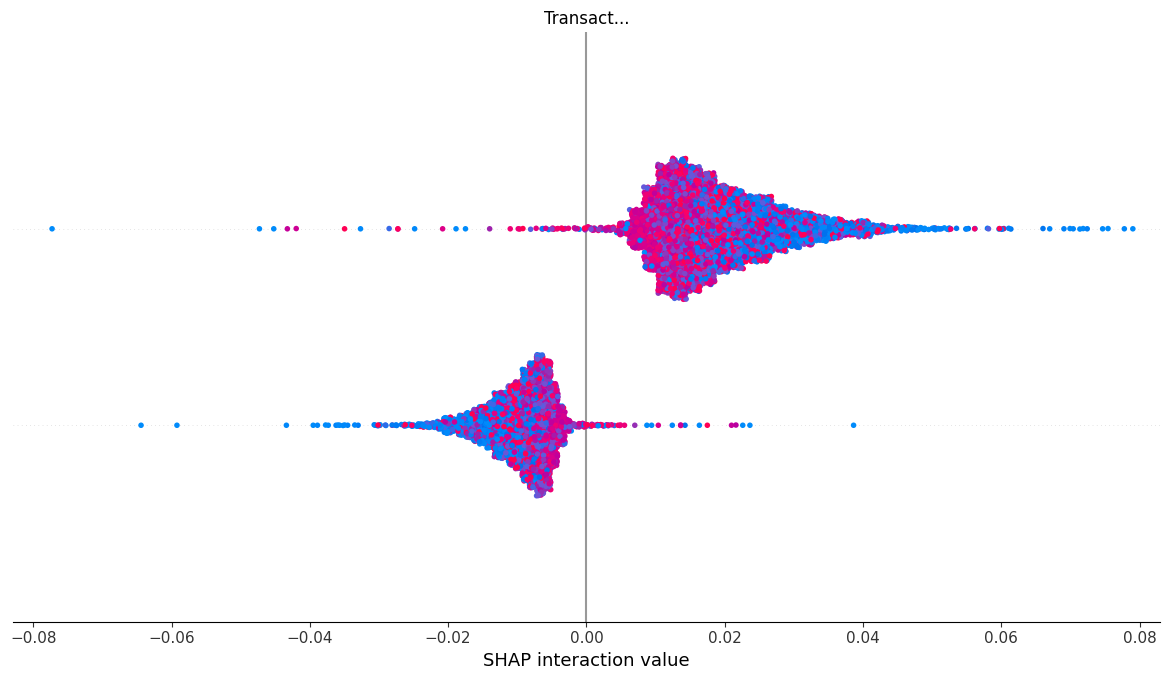

In [16]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Échantillonnage pour aller vite
X = train_df.drop(columns=['isFraud'])
y = train_df['isFraud']
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=5000, stratify=y, random_state=42)

# Modèle Random Forest
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_sample, y_sample)

# SHAP avec TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Choix automatique selon le format
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], X_sample)  # classe 1 = fraude
else:
    shap.summary_plot(shap_values, X_sample)


## Définition  :

SHAP (SHapley Additive exPlanations) est une méthode d’interprétation qui explique l’impact de chaque variable sur la prédiction d’un modèle de machine learning, en s'appuyant sur la théorie des jeux.
## Interprétation du graphe SHAP  :

    Le graphe montre que certaines variables (non visibles ici car tronquées) ont un impact plus fort sur la prédiction de fraude, avec des valeurs SHAP plus éloignées de 0.

    Les points rouges correspondent à des valeurs élevées d'une feature, les bleus à des valeurs faibles ; leur position sur l'axe horizontal montre si cela augmente ou diminue la prédiction de fraude.

    Ce nuage dense indique que le modèle Random Forest s’appuie fortement sur quelques variables clés pour discriminer les comportements suspects.

## 2. SHAP Bar Plot (Importance globale des features)

Mémoire disponible : 1.53 GB
Type des valeurs SHAP : <class 'numpy.ndarray'>
Forme des valeurs SHAP : (10, 421, 2)
Forme des valeurs SHAP sélectionnées : (10, 421)
Forme de X_sample : (10, 421)


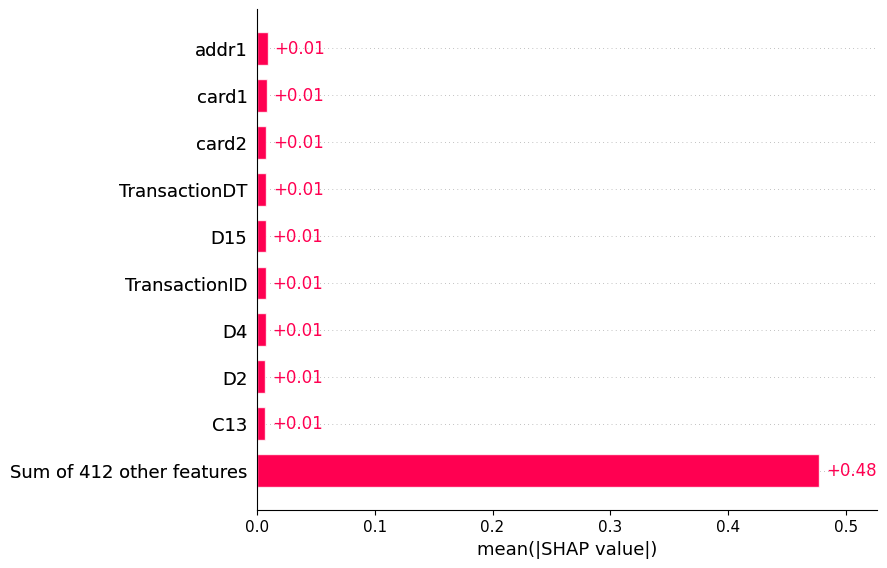

In [19]:
import shap
import numpy as np
import pandas as pd
import psutil  # Pour vérifier la mémoire disponible

# Supposons que X soit votre jeu de données et y les étiquettes correspondantes
# X est votre DataFrame de caractéristiques
# y est votre série d'étiquettes

# Vérifiez la mémoire disponible
available_memory = psutil.virtual_memory().available
print(f"Mémoire disponible : {available_memory / (1024 ** 3):.2f} GB")

# Déterminer la taille de l'échantillon en fonction de la mémoire disponible
# Par exemple, si vous avez moins de 2 GB de mémoire disponible, réduisez encore plus la taille de l'échantillon
if available_memory < 2 * (1024 ** 3):  # 2 GB
    sample_size = 10  # Très petit échantillon
else:
    sample_size = 50  # Petit échantillon

# Échantillonner aléatoirement à partir de l'ensemble du jeu de données
X_sample = X.sample(n=sample_size, random_state=42)

# Calculer les valeurs SHAP pour l'échantillon
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Vérifiez la structure des valeurs SHAP
print("Type des valeurs SHAP :", type(shap_values))
print("Forme des valeurs SHAP :", [sv.shape for sv in shap_values] if isinstance(shap_values, list) else shap_values.shape)

# Si le modèle est un classifieur multi-classes, shap_values sera une liste de tableaux
# Sélectionnez les valeurs SHAP pour la classe qui vous intéresse
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Changez l'indice si nécessaire pour la classe qui vous intéresse
else:
    shap_values_class = shap_values

# Vérifiez si les valeurs SHAP incluent une colonne de biais
if shap_values_class.ndim == 3:
    shap_values_class = shap_values_class[:, :, 0]  # Sélectionnez la première classe

print("Forme des valeurs SHAP sélectionnées :", shap_values_class.shape)
print("Forme de X_sample :", X_sample.shape)

# Assurez-vous que le nombre de caractéristiques correspond
assert shap_values_class.shape[1] == X_sample.shape[1], "Incompatibilité dans le nombre de caractéristiques"

# Calculer la valeur absolue moyenne des valeurs SHAP pour chaque caractéristique
shap_abs_mean = np.abs(shap_values_class).mean(axis=0)

# Créer un DataFrame pour les valeurs SHAP moyennes
shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_abs_mean': shap_abs_mean
})

# Trier les caractéristiques par importance
shap_df = shap_df.sort_values(by='shap_abs_mean', ascending=False)

# Créer un objet Explanation à partir des valeurs SHAP
shap_explanation = shap.Explanation(values=shap_values_class, base_values=explainer.expected_value, data=X_sample.values, feature_names=X_sample.columns)

# SHAP Bar Plot - Importance globale des caractéristiques
shap.plots.bar(shap_explanation)


##  3. SHAP Dependence Plot (relation entre une variable et la prédiction)

Mémoire disponible : 1.38 GB
Type des valeurs SHAP : <class 'numpy.ndarray'>
Forme des valeurs SHAP : (10, 421, 2)
Forme des valeurs SHAP sélectionnées : (10, 421)
Forme de X_sample : (10, 421)


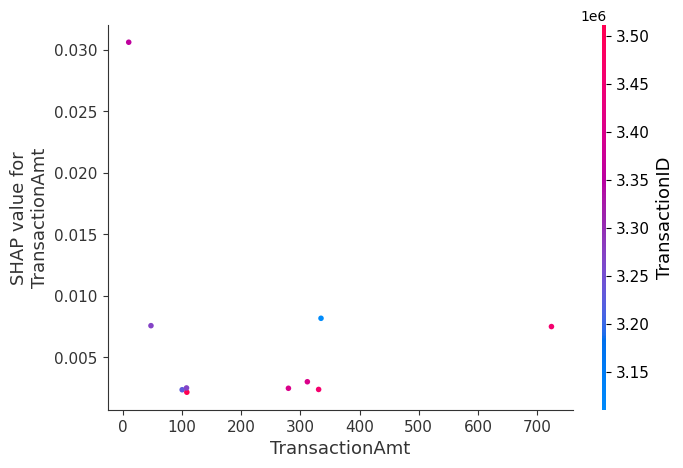

In [24]:
import shap
import numpy as np
import pandas as pd
import psutil  # Pour vérifier la mémoire disponible

# Supposons que X soit votre jeu de données et y les étiquettes correspondantes
# X est votre DataFrame de caractéristiques
# y est votre série d'étiquettes

# Vérifiez la mémoire disponible
available_memory = psutil.virtual_memory().available
print(f"Mémoire disponible : {available_memory / (1024 ** 3):.2f} GB")

# Déterminer la taille de l'échantillon en fonction de la mémoire disponible
# Par exemple, si vous avez moins de 2 GB de mémoire disponible, réduisez encore plus la taille de l'échantillon
if available_memory < 2 * (1024 ** 3):  # 2 GB
    sample_size = 10  # Très petit échantillon
else:
    sample_size = 50  # Petit échantillon

# Échantillonner aléatoirement à partir de l'ensemble du jeu de données
X_sample = X.sample(n=sample_size, random_state=42)

# Calculer les valeurs SHAP pour l'échantillon
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Vérifiez la structure des valeurs SHAP
print("Type des valeurs SHAP :", type(shap_values))
print("Forme des valeurs SHAP :", [sv.shape for sv in shap_values] if isinstance(shap_values, list) else shap_values.shape)

# Si le modèle est un classifieur multi-classes, shap_values sera une liste de tableaux
# Sélectionnez les valeurs SHAP pour la classe qui vous intéresse
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Changez l'indice si nécessaire pour la classe qui vous intéresse
else:
    shap_values_class = shap_values

# Vérifiez si les valeurs SHAP incluent une colonne de biais
if shap_values_class.ndim == 3:
    shap_values_class = shap_values_class[:, :, 0]  # Sélectionnez la première classe

print("Forme des valeurs SHAP sélectionnées :", shap_values_class.shape)
print("Forme de X_sample :", X_sample.shape)

# Assurez-vous que le nombre de caractéristiques correspond
assert shap_values_class.shape[1] == X_sample.shape[1], "Incompatibilité dans le nombre de caractéristiques"

# Calculer la valeur absolue moyenne des valeurs SHAP pour chaque caractéristique
shap_abs_mean = np.abs(shap_values_class).mean(axis=0)

# Créer un DataFrame pour les valeurs SHAP moyennes
shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_abs_mean': shap_abs_mean
})

# Trier les caractéristiques par importance
shap_df = shap_df.sort_values(by='shap_abs_mean', ascending=False)

# Créer un objet Explanation à partir des valeurs SHAP
shap_explanation = shap.Explanation(values=shap_values_class, base_values=explainer.expected_value, data=X_sample.values, feature_names=X_sample.columns)


# Pour une variable spécifique, ex : "TransactionAmt"
shap.dependence_plot("TransactionAmt", shap_values_class, X_sample)


## 4. SHAP Force Plot (interprétation individuelle d'une prédiction)

Mémoire disponible : 1.30 GB
Type des valeurs SHAP : <class 'numpy.ndarray'>
Forme des valeurs SHAP : (10, 421, 2)
Forme des valeurs SHAP sélectionnées : (10, 421)
Forme de X_sample : (10, 421)


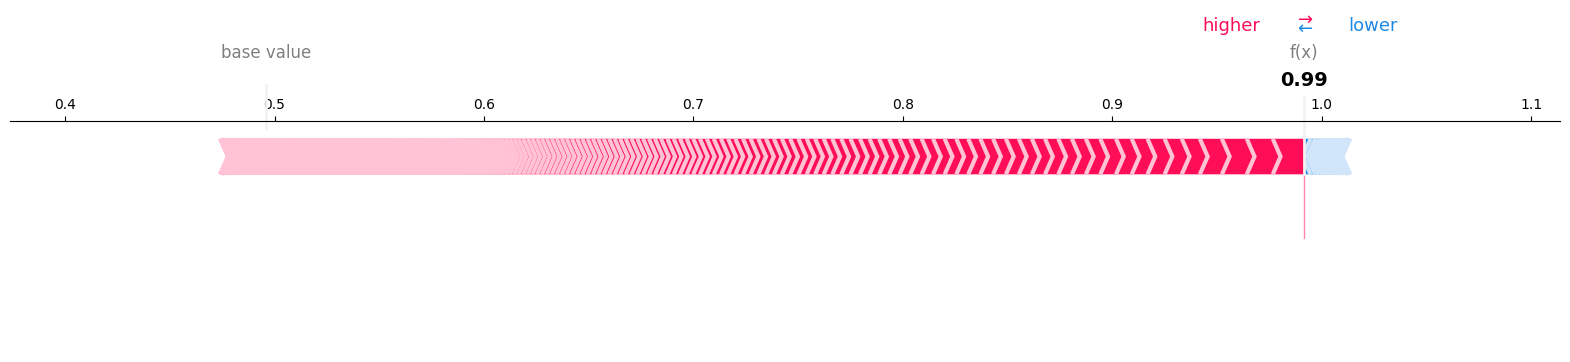

In [25]:
import shap
import numpy as np
import pandas as pd
import psutil  # Pour vérifier la mémoire disponible

# Supposons que X soit votre jeu de données et y les étiquettes correspondantes
# X est votre DataFrame de caractéristiques
# y est votre série d'étiquettes

# Vérifiez la mémoire disponible
available_memory = psutil.virtual_memory().available
print(f"Mémoire disponible : {available_memory / (1024 ** 3):.2f} GB")

# Déterminer la taille de l'échantillon en fonction de la mémoire disponible
# Par exemple, si vous avez moins de 2 GB de mémoire disponible, réduisez encore plus la taille de l'échantillon
if available_memory < 2 * (1024 ** 3):  # 2 GB
    sample_size = 10  # Très petit échantillon
else:
    sample_size = 50  # Petit échantillon

# Échantillonner aléatoirement à partir de l'ensemble du jeu de données
X_sample = X.sample(n=sample_size, random_state=42)

# Calculer les valeurs SHAP pour l'échantillon
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Vérifiez la structure des valeurs SHAP
print("Type des valeurs SHAP :", type(shap_values))
print("Forme des valeurs SHAP :", [sv.shape for sv in shap_values] if isinstance(shap_values, list) else shap_values.shape)

# Si le modèle est un classifieur multi-classes, shap_values sera une liste de tableaux
# Sélectionnez les valeurs SHAP pour la classe qui vous intéresse
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Changez l'indice si nécessaire pour la classe qui vous intéresse
else:
    shap_values_class = shap_values

# Vérifiez si les valeurs SHAP incluent une colonne de biais
if shap_values_class.ndim == 3:
    shap_values_class = shap_values_class[:, :, 0]  # Sélectionnez la première classe

print("Forme des valeurs SHAP sélectionnées :", shap_values_class.shape)
print("Forme de X_sample :", X_sample.shape)

# Assurez-vous que le nombre de caractéristiques correspond
assert shap_values_class.shape[1] == X_sample.shape[1], "Incompatibilité dans le nombre de caractéristiques"

# Calculer la valeur absolue moyenne des valeurs SHAP pour chaque caractéristique
shap_abs_mean = np.abs(shap_values_class).mean(axis=0)

# Créer un DataFrame pour les valeurs SHAP moyennes
shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_abs_mean': shap_abs_mean
})

# Trier les caractéristiques par importance
shap_df = shap_df.sort_values(by='shap_abs_mean', ascending=False)

# Créer un objet Explanation à partir des valeurs SHAP
shap_explanation = shap.Explanation(values=shap_values_class, base_values=explainer.expected_value, data=X_sample.values, feature_names=X_sample.columns)


# Pour un individu i (exemple : i=0)
i = 0
shap.force_plot(explainer.expected_value[1], shap_values_class[i], X_sample.iloc[i], matplotlib=True)


##  5. SHAP Decision Plot (chemin de décision pour une instance)

Mémoire disponible : 2.14 GB
Type des valeurs SHAP : <class 'numpy.ndarray'>
Forme des valeurs SHAP : (50, 421, 2)
Forme des valeurs SHAP sélectionnées : (50, 421)
Forme de X_sample : (50, 421)


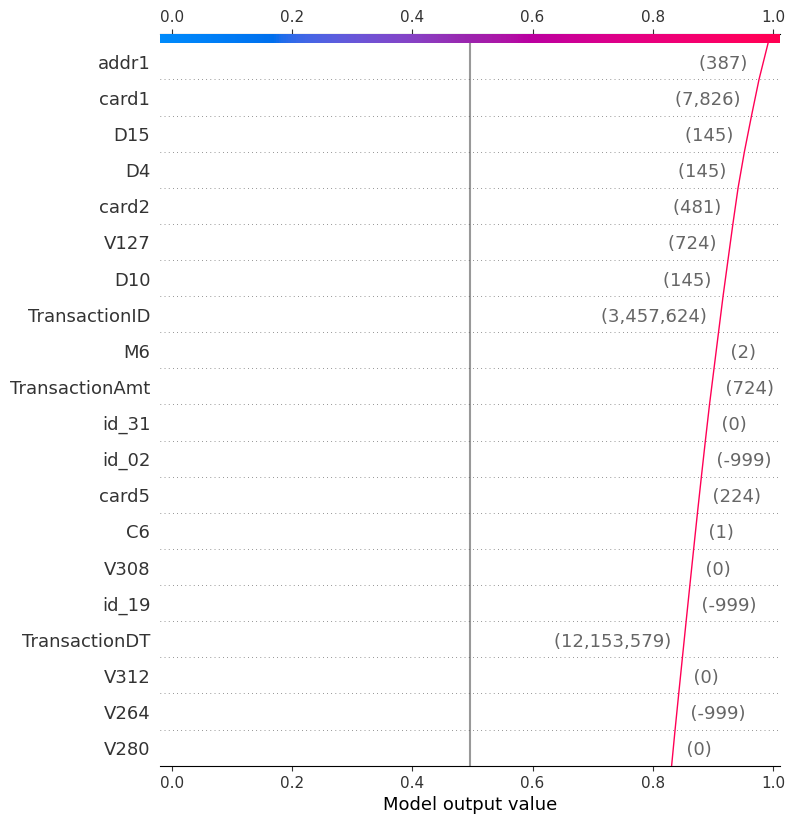

In [29]:
import shap
import numpy as np
import pandas as pd
import psutil  # Pour vérifier la mémoire disponible

# Supposons que X soit votre jeu de données et y les étiquettes correspondantes
# X est votre DataFrame de caractéristiques
# y est votre série d'étiquettes

# Vérifiez la mémoire disponible
available_memory = psutil.virtual_memory().available
print(f"Mémoire disponible : {available_memory / (1024 ** 3):.2f} GB")

# Déterminer la taille de l'échantillon en fonction de la mémoire disponible
# Par exemple, si vous avez moins de 2 GB de mémoire disponible, réduisez encore plus la taille de l'échantillon
if available_memory < 2 * (1024 ** 3):  # 2 GB
    sample_size = 10  # Très petit échantillon
else:
    sample_size = 50  # Petit échantillon

# Échantillonner aléatoirement à partir de l'ensemble du jeu de données
X_sample = X.sample(n=sample_size, random_state=42)

# Calculer les valeurs SHAP pour l'échantillon
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Vérifiez la structure des valeurs SHAP
print("Type des valeurs SHAP :", type(shap_values))
print("Forme des valeurs SHAP :", [sv.shape for sv in shap_values] if isinstance(shap_values, list) else shap_values.shape)

# Si le modèle est un classifieur multi-classes, shap_values sera une liste de tableaux
# Sélectionnez les valeurs SHAP pour la classe qui vous intéresse
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Changez l'indice si nécessaire pour la classe qui vous intéresse
else:
    shap_values_class = shap_values

# Vérifiez si les valeurs SHAP incluent une colonne de biais
if shap_values_class.ndim == 3:
    shap_values_class = shap_values_class[:, :, 0]  # Sélectionnez la première classe

print("Forme des valeurs SHAP sélectionnées :", shap_values_class.shape)
print("Forme de X_sample :", X_sample.shape)

# Assurez-vous que le nombre de caractéristiques correspond
assert shap_values_class.shape[1] == X_sample.shape[1], "Incompatibilité dans le nombre de caractéristiques"

# Calculer la valeur absolue moyenne des valeurs SHAP pour chaque caractéristique
shap_abs_mean = np.abs(shap_values_class).mean(axis=0)

# Créer un DataFrame pour les valeurs SHAP moyennes
shap_df = pd.DataFrame({
    'feature': X_sample.columns,
    'shap_abs_mean': shap_abs_mean
})

# Trier les caractéristiques par importance
shap_df = shap_df.sort_values(by='shap_abs_mean', ascending=False)

# Créer un objet Explanation à partir des valeurs SHAP
shap_explanation = shap.Explanation(values=shap_values_class, base_values=explainer.expected_value, data=X_sample.values, feature_names=X_sample.columns)

# Pour un individu i (exemple : i=0)
i = 0

# Convertir X_sample.columns en liste
feature_names = list(X_sample.columns)

# Decision plot pour un individu i (exemple : i=0)
shap.decision_plot(explainer.expected_value[1], shap_values_class[i], X_sample.iloc[i], feature_names=feature_names)


## 6. SHAP Waterfall Plot (détail de l’impact des features pour une instance)

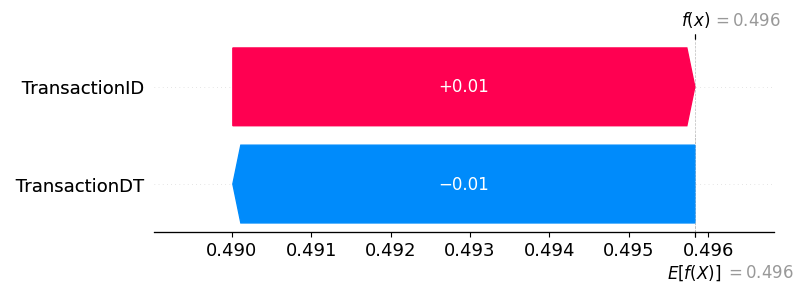

In [30]:
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1], shap_values[1][i], X_sample.iloc[i]
)


shap_values[1] shape: (421, 2)
X_sample shape: (5000, 421)


## lister les features les plus importantes avec SHAP

In [32]:
import numpy as np
import pandas as pd

# Assurez-vous que shap_values et X_sample sont définis avant cette étape
# Par exemple :
# shap_values = ...  # Valeurs SHAP calculées
# X_sample = ...     # Échantillon de données avec des noms de colonnes

# Vérifiez la forme de shap_values
print("Forme des valeurs SHAP :", shap_values.shape)

# Si shap_values est une liste (par exemple, pour un classifieur multi-classes), sélectionnez la classe qui vous intéresse
if isinstance(shap_values, list):
    shap_values_class = shap_values[1]  # Changez l'indice si nécessaire pour la classe qui vous intéresse
else:
    shap_values_class = shap_values

# Vérifiez si les valeurs SHAP incluent une colonne de biais
if shap_values_class.ndim == 3:
    shap_values_class = shap_values_class[:, :, 0]  # Sélectionnez la première classe

# Récupérer l’importance moyenne de chaque variable
feature_importance = np.abs(shap_values_class).mean(axis=0)

# Vérifiez que feature_importance est unidimensionnel
if feature_importance.ndim != 1:
    raise ValueError("feature_importance doit être un tableau unidimensionnel.")

# Associer avec les noms de colonnes
importance_df = pd.DataFrame({
    "Feature": X_sample.columns,
    "SHAP_Importance": feature_importance
}).sort_values(by="SHAP_Importance", ascending=False)

# Afficher les 10 plus importantes
print(importance_df.head(10))


Forme des valeurs SHAP : (50, 421, 2)
            Feature  SHAP_Importance
5             card2         0.009624
0     TransactionID         0.009226
4             card1         0.008787
1     TransactionDT         0.008276
10            addr1         0.007824
2    TransactionAmt         0.007477
27              C13         0.006974
30               D2         0.006964
411           id_31         0.006612
42              D15         0.006433


## Installer MLflow et configurer un tracking simple

### Installe MLFLOW

In [7]:
!pip install mlflow



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Préparation des données
X = train_df.drop(columns=['isFraud'])
y = train_df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Lancement du tracking MLflow
with mlflow.start_run():
    model = LogisticRegression(max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    # Enregistrement du modèle et des métriques
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_metric("auc", auc)
    mlflow.sklearn.log_model(model, "model")

    print(f"🎯 AUC = {auc:.4f}")


C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/05/01 02:36:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🎯 AUC = 0.7785


## MLflow ?
est une plateforme open-source pour gérer le cycle de vie des modèles de machine learning.

Le modèle a une performance modérée avec un AUC de 0.7785.

## Lancer le MLFLOW dans le terminal avec mlflow ui


### Pipeline final

In [9]:
# pipeline.py

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import mlflow
import mlflow.sklearn

# Fonction personnalisée pour le nettoyage
def clean_dataframe(df, missing_thresh=0.9):
    missing = df.isnull().mean()
    to_drop = missing[missing > missing_thresh].index
    df = df.drop(columns=to_drop, errors='ignore')
    df = df.fillna(-999)
    return df

# Fonction personnalisée pour encoder les catégories
def encode_categoricals(df):
    for col in df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

# Wrapper pour fonction personnalisée dans le pipeline
def custom_preprocessing(X):
    X = clean_dataframe(X)
    X = encode_categoricals(X)
    return X

# Pipeline scikit-learn
preprocess_step = FunctionTransformer(custom_preprocessing, validate=False)
model = LogisticRegression(max_iter=1000, class_weight='balanced')
pipeline = Pipeline([
    ('preprocessing', preprocess_step),
    ('classifier', model)
])

# Fonction complète pour entraîner et logguer avec MLflow
def run_pipeline(train_df):
    X = train_df.drop(columns=["isFraud"])
    y = train_df["isFraud"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    with mlflow.start_run():
        pipeline.fit(X_train, y_train)
        y_proba = pipeline.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

        mlflow.log_param("model", "LogisticRegression pipeline")
        mlflow.log_metric("roc_auc", auc)
        mlflow.sklearn.log_model(pipeline, "fraud_model")

        print(f"\n🎯 AUC : {auc:.4f}")
        print("\n📋 Rapport de classification :")
        print(classification_report(y_test, pipeline.predict(X_test)))




# Exemple d'utilisation du Pipeline

In [10]:
import sys
import pandas as pd

# Ajouter le chemin où se trouve pipeline.py
sys.path.append("C:/Users/DELL/OneDrive/Desktop/ISE_2_PAC_Semestre_2/Projet_ML_class")



# Charger un échantillon des données
df = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/ISE_2_PAC_Semestre_2/Projet_ML_class/train_transaction.csv", nrows=5000)
df_id = pd.read_csv("C:/Users/DELL/OneDrive/Desktop/ISE_2_PAC_Semestre_2/Projet_ML_class/train_identity.csv", nrows=5000)
train_df = pd.merge(df, df_id, on="TransactionID", how="left")

# Exécuter le pipeline
run_pipeline(train_df)


C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/05/01 02:36:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



🎯 AUC : 0.5389

📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       978
           1       0.04      0.41      0.07        22

    accuracy                           0.75      1000
   macro avg       0.51      0.58      0.46      1000
weighted avg       0.96      0.75      0.84      1000



## Un pipeline ?
en machine learning est un ensemble séquentiel de transformations de données et d'étapes de modélisation, permettant d'automatiser et de standardiser le processus de traitement des données.

## Interprétation
Le pipeline a une performance médiocre avec un AUC de 0.5389, indiquant une capacité limitée à distinguer les classes. Le rapport de classification montre une précision élevée (0.98) et un rappel modéré (0.76) pour la classe 0, mais une précision très faible (0.04) et un rappel modéré (0.41) pour la classe 1, ce qui suggère que le modèle prédit mal la classe minoritaire. L'accuracy globale est de 0.75, mais ce chiffre est trompeur en raison du déséquilibre des classes, comme le montre la faible moyenne pondérée du F1-score (0.46

## Sauvegarder Le Pipeline


In [11]:
import joblib  # en haut de ton fichier

# ...

# À la fin de la fonction run_pipeline :
joblib.dump(pipeline, "C:/Users/DELL/OneDrive/Desktop/ISE_2_PAC_Semestre_2/Projet_ML_class/fraud_pipeline.pkl")
print("✅ Pipeline sauvegardé avec succès.")


✅ Pipeline sauvegardé avec succès.


## Application


## Application Vesta – Détection de Fraude en Ligne
Objectif

L'application Vesta permet de prédire automatiquement si une transaction est frauduleuse ou non, à partir d’un modèle de machine learning entraîné sur les données de la compétition IEEE-CIS Fraud Detection. Elle est destinée à être utilisée par des analystes, développeurs ou agents anti-fraude dans un contexte opérationnel.
## Fonctionnalités principales
### 1. Chargement d’un fichier CSV

    L’utilisateur peut téléverser un fichier .csv contenant une ou plusieurs transactions.

    L’application :

    affiche les premières lignes du fichier

    prédit la probabilité de fraude pour chaque transaction

    affiche les résultats sous forme de tableau avec :

            isFraud_Pred : 0 (non fraude) ou 1 (fraude)

            Fraud_Proba : score de probabilité entre 0 et 1

### 2. Saisie manuelle d’une transaction

    L’utilisateur peut entrer les informations d’une transaction simulée à la main :

        Montant de la transaction (TransactionAmt)

        Type d’appareil utilisé (DeviceType) : desktop ou mobile

        Identifiant de carte (card1)

    Une fois les données saisies, un clic sur “Prédire cette transaction” :

        donne une réponse immédiate : Transaction normale ou  Fraude probable

        indique la probabilité de fraude (%)



In [16]:
# streamlit_app.py

import streamlit as st
import pandas as pd
import joblib

# Charger le pipeline sauvegardé
@st.cache_resource
def load_model():
   return joblib.load("C:/Users/DELL/OneDrive/Desktop/ISE_2_PAC_Semestre_2/Projet_ML_class/fraud_pipeline.pkl")


pipeline = load_model()

st.title("🔍 Vesta - Détection de Fraude en Ligne")
st.write("Chargez une transaction ou entrez les données manuellement pour savoir si elle est frauduleuse.")

# Mode 1 : Charger un fichier CSV
uploaded_file = st.file_uploader("Chargez un fichier CSV avec des transactions", type=["csv"])

if uploaded_file is not None:
    input_df = pd.read_csv(uploaded_file)
    st.write("### Aperçu des données chargées :", input_df.head())

    if st.button("Prédire"): 
        prediction = pipeline.predict(input_df)
        prediction_proba = pipeline.predict_proba(input_df)[:, 1]

        input_df['isFraud_Pred'] = prediction
        input_df['Fraud_Proba'] = prediction_proba

        st.write("### Résultats :")
        st.dataframe(input_df[['isFraud_Pred', 'Fraud_Proba']].head())

# Mode 2 : Saisie manuelle (simple)
with st.expander("Ou entrez une transaction manuellement"):
    montant = st.number_input("Montant de la transaction (TransactionAmt)", min_value=0.0, step=1.0)
    device_type = st.selectbox("Type de device", options=['desktop', 'mobile'])
    card1 = st.number_input("card1 (ex : 10000)", step=1)

    if st.button("Prédire cette transaction"):
        input_manual = pd.DataFrame({
            'TransactionAmt': [montant],
            'DeviceType': [device_type],
            'card1': [card1],
        })

        prediction = pipeline.predict(input_manual)[0]
        proba = pipeline.predict_proba(input_manual)[0][1]

        st.markdown(f"### Résultat : {'❗Fraude probable' if prediction else '✅ Transaction normale'}")
        st.markdown(f"Probabilité de fraude : **{proba:.2%}**")


2025-05-01 03:54:28.344 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 03:54:28.346 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 03:54:28.350 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 03:54:28.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 03:54:28.353 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 03:54:28.355 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 03:54:28.357 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 03:54:28.359 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [23]:
!streamlit run streamlit_app.py




Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: streamlit_app.py


In [22]:
!streamlit run "C:/Users/DELL/OneDrive/Desktop/ISE_2_PAC_Semestre_2/Projet_ML_class/streamlit_app.py"


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: C:/Users/DELL/OneDrive/Desktop/ISE_2_PAC_Semestre_2/Projet_ML_class/streamlit_app.py
